In [ ]:
# Material last updated: 29 Feb 2024
# Note: this notebook was designed with the Roboto Condensed font, which can be installed here: https://www.1001fonts.com/roboto-condensed-font.html

from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')

# Location Project - Scoring AUS Cities ranking "bustling scores"

In [ ]:
# Required basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# For location data
import geopandas as gpd
from geoalchemy2 import Geometry, WKTElement
from shapely.geometry import Point, Polygon, MultiPolygon

# Taking SQL into code
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open (credential_filepath) as f:
        db_conn_dict = json.load(f)
        host = db_conn_dict['host']
        db_user = db_conn_dict['user']
        db_pw = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port = db_conn_dict['port']
        
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
            
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
            
        return db,conn
    
def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result

    except Exception as e:
        print("Error encountered: ", e, sep='\n')

    return result

The below cell connects to the database

In [3]:
db, conn = pgconnect(credentials)

Connected successfully.


The below query confirms that PostGIS is correctly configured to the notebook, because geographical operations will rely on PostGIS and thus require the connection.

In [4]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.4 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


We set SRID TO 4326 following the WGS84 world geodetic coordinate system used by the data sets.

In [5]:
srid = 4326

## 1.0 Import and Clean all Dataset

### 1.1 Population (CSV)

Reading the population CSV file and checking its shape and table.

In [6]:
Population = pd.read_csv('Population.csv')
print("Shape of the data:", Population.shape)
Population.head()

Shape of the data: (373, 21)


,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346


Making a copy of the original to use for cleaning.

In [7]:
PopulationWRK = Population.copy()
# Keeping a copy of the original data

Dropping all rows that do not have a SA2 code or name, since they are indicators of the region. Without them, we cannot determine what SA2 zones they are with are whether they are valid or not.

Luckily, there are no nulls.

In [8]:
PopulationWRK.dropna(subset=["sa2_code"], inplace = True)
PopulationWRK.dropna(subset=["sa2_name"], inplace = True)

PopulationWRK.shape
# Removing all rows that does not have a code or name since they will be redundant values
# where are those people from if we do not know the codes/names?

(373, 21)

Checking data types to see if any cleaning and transforming is necessary.

In [9]:
PopulationWRK.dtypes
# checking if the data types are correct
# looking at this, they are aligned

sa2_code               int64
sa2_name              object
0-4_people             int64
5-9_people             int64
10-14_people           int64
15-19_people           int64
20-24_people           int64
25-29_people           int64
30-34_people           int64
35-39_people           int64
40-44_people           int64
45-49_people           int64
50-54_people           int64
55-59_people           int64
60-64_people           int64
65-69_people           int64
70-74_people           int64
75-79_people           int64
80-84_people           int64
85-and-over_people     int64
total_people           int64
dtype: object

Taking the columns of the ages of people and adding them to check if they really end up the same as the total amount just in case.

In [10]:
col_list = ['0-4_people',
            '5-9_people',
            '10-14_people',
            '15-19_people',
            '20-24_people',
            '25-29_people',
            '30-34_people',
            '35-39_people',
            '40-44_people',
            '45-49_people',
            '50-54_people',
            '55-59_people',
            '60-64_people',
            '65-69_people',
            '70-74_people',
            '75-79_people',
            '80-84_people',
            '85-and-over_people'
           ]
PopulationWRK['Sum'] = PopulationWRK[col_list].sum(axis=1)
PopulationWRK['Equal?'] = (PopulationWRK['total_people'] == PopulationWRK['Sum'])
PopulationWRK.head()

if (PopulationWRK['Equal?'].value_counts()[True] == 373):
    print ("All values summed correctly.")
# Checking if it is directly equal. Since the shape and count here both equal 373, all total_people is correct

All values summed correctly.


Now checking if there exists any null values that were ignored earlier.

Luckily there are none.

In [11]:
# Checking nulls
null_count = PopulationWRK.isnull().sum().sum()
print ("Number of missing values: ", null_count)

# With no missing values, we now know this CSV file is clean from this area at least

Number of missing values:  0


Delete the columns that we added just now since they will be redundant/useless

In [12]:
del PopulationWRK['Sum']
del PopulationWRK['Equal?']
# Deleting the two columns that was used to check whether the sum equal
# Have to restart kernels to make this work, since deleting it means its gone!!!
# So if kernel is ran again, it will not work

PopulationWRK.head()

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346


Renaming the columns to a sensible name, mainly due to the fact most coding languages do not accept variables that start with numbers.

In [13]:
PopulationWRK.rename(columns={
    '0-4_people': 'age0_to_4',
    '5-9_people': 'age5_to_9',
    '10-14_people': 'age10_to_14',
    '15-19_people': 'age15_to_19',
    '20-24_people': 'age20_to_24',
    '25-29_people': 'age25_to_29',
    '30-34_people': 'age30_to_34',
    '35-39_people': 'age35_to_39',
    '40-44_people': 'age40_to_44',
    '45-49_people': 'age45_to_49',
    '50-54_people': 'age50_to_54',
    '55-59_people': 'age55_to_59',
    '60-64_people': 'age60_to_64',
    '65-69_people': 'age65_to_69',
    '70-74_people': 'age70_to_74',
    '75-79_people': 'age75_to_79',
    '80-84_people': 'age80_to_84',
    '85-and-over_people': 'age85plus',
    'total_people': 'total_population'
}, inplace = True)

PopulationWRK.head()

,sa2_code,sa2_name,age0_to_4,age5_to_9,age10_to_14,age15_to_19,age20_to_24,age25_to_29,age30_to_34,age35_to_39,...,age45_to_49,age50_to_54,age55_to_59,age60_to_64,age65_to_69,age70_to_74,age75_to_79,age80_to_84,age85plus,total_population
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346


### 1.2 Polling Places 2019 (CSV)

Reading the Polling Places CSV file and checking its shape and table.

In [14]:
PollingPlaces = pd.read_csv("PollingPlaces2019.csv")
print ("Shape of this data: ", PollingPlaces.shape)
PollingPlaces.head()

Shape of this data:  (2930, 17)


,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,ORANGE,NSW,2800.0,NaN,NaN,NaN
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN


Checking the data types of each column to see if any columns need to be transformed

In [15]:
PollingPlacesWRK = PollingPlaces.copy()
# Keeping a copy of original data

PollingPlacesWRK.dropna(subset=["FID"], inplace = True)
PollingPlacesWRK.dropna(subset=["state"], inplace = True)
PollingPlacesWRK.dropna(subset=["division_id"], inplace = True)
PollingPlacesWRK.dropna(subset=["division_name"], inplace = True)
PollingPlacesWRK.dropna(subset=["polling_place_id"], inplace = True)
PollingPlacesWRK.dropna(subset=["polling_place_type_id"], inplace = True)
PollingPlacesWRK.dropna(subset=["polling_place_name"], inplace = True)
PollingPlacesWRK.dropna(subset=["premises_name"], inplace = True)
# Removing all general null cases first if any in these columns.
# Since these columns are what you'd definitely expect from a polling place (legal reasons)
# If they do not exist, they are removed.

PollingPlacesWRK.shape

(2930, 17)

Checking if any data types need to be transformed.

In [16]:
PollingPlacesWRK.dtypes

FID                             object
state                           object
division_id                      int64
division_name                   object
polling_place_id                 int64
polling_place_type_id            int64
polling_place_name              object
premises_name                   object
premises_address_1              object
premises_address_2              object
premises_address_3              object
premises_suburb                 object
premises_state_abbreviation     object
premises_post_code             float64
latitude                       float64
longitude                      float64
the_geom                        object
dtype: object

Within this CSV file there are a lot of missing values. One decision that was made is that not all missing values are necessarily bad, but more so just are not needed. However, the one column that is quite important would be geom. This column tells us exactly where a polling place is. Even without the name of premise for example, if the location is known through spatial data, we can use that to acknowledge its actual location.

This goes without saying, that the latitude and longtitude is just as important since the geom essentially takes those two to form a cordinate. But, if the geom exists, it itself is an inference that there is latitude and longtitude, so it is not that major.

In [17]:
PollingPlacesWRK.dropna(subset=["the_geom"], inplace = True)
PollingPlacesWRK.shape

PollingPlacesWRK.head()

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom
13,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,58,1,Oatley,Oatley Public School,51 Letitia St,NaN,NaN,OATLEY,NSW,2223.0,-33.98470,151.081000,POINT (-33.9847 151.081)
15,aec_federal_election_polling_places_2019.fid-4...,NSW,111,Chifley,392,1,Dharruk,Dawson Public School,7 Stuart Rd,NaN,NaN,DHARRUK,NSW,2770.0,-33.74750,150.817000,POINT (-33.7475 150.817)
16,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,31,1,Allawah,PJ Ferry Reserve Community Hall,147B Bellevue Pde,NaN,NaN,ALLAWAH,NSW,2218.0,-33.97679,151.114897,POINT (-33.9767897 151.1148974)
17,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,67,1,Allawah South,St Raphael's Church Hall,84 George St,NaN,NaN,SOUTH HURSTVILLE,NSW,2221.0,-33.97560,151.111000,POINT (-33.9756 151.111)
18,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,56500,1,Beverly Hills North (Banks),Beverly Hills North Public School,1-3 Shorter Ave,NaN,NaN,BEVERLY HILLS,NSW,2209.0,-33.94130,151.075000,POINT (-33.9413 151.075)


Renaming the geom column to just 'geom' so it is easier to use later. And FID to lowercase so it matches SQL low case detection.
Create geom column using function.
Remove the latitude and longitude fields since we have geom now.

In [18]:
PollingPlacesWRK.rename(columns={
    'the_geom': 'geom',
    'FID': 'fid'
}, inplace = True)


#Creates geom column using longtitude and latitude
PollingPlacesWRK['geom'] = gpd.points_from_xy(PollingPlacesWRK.longitude, PollingPlacesWRK.latitude)
#Removing the old latitude/longitude fields
PollingPlacesWRK = PollingPlacesWRK.drop(columns=['latitude', 'longitude'])

PollingPlacesWRK.head()

,fid,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,geom
13,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,58,1,Oatley,Oatley Public School,51 Letitia St,NaN,NaN,OATLEY,NSW,2223.0,POINT (151.08100 -33.98470)
15,aec_federal_election_polling_places_2019.fid-4...,NSW,111,Chifley,392,1,Dharruk,Dawson Public School,7 Stuart Rd,NaN,NaN,DHARRUK,NSW,2770.0,POINT (150.81700 -33.74750)
16,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,31,1,Allawah,PJ Ferry Reserve Community Hall,147B Bellevue Pde,NaN,NaN,ALLAWAH,NSW,2218.0,POINT (151.11490 -33.97679)
17,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,67,1,Allawah South,St Raphael's Church Hall,84 George St,NaN,NaN,SOUTH HURSTVILLE,NSW,2221.0,POINT (151.11100 -33.97560)
18,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,56500,1,Beverly Hills North (Banks),Beverly Hills North Public School,1-3 Shorter Ave,NaN,NaN,BEVERLY HILLS,NSW,2209.0,POINT (151.07500 -33.94130)


Change geom into WKT form

In [19]:
PollingPlacesWRK['geom'] = PollingPlacesWRK['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

Since we only concern about Greater sydney region and we will complete queries through geom (coordinates) instead of state, we can remove the state column and premises_state_abbreviation column. We can also remove polling_place_type_id column as polling place type doesn't contributes to our analysis.

In [20]:
PollingPlacesWRK = PollingPlacesWRK.drop(columns=['state', 'premises_state_abbreviation', 'polling_place_type_id'])
PollingPlacesWRK

,fid,division_id,division_name,polling_place_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_post_code,geom
13,aec_federal_election_polling_places_2019.fid-4...,103,Banks,58,Oatley,Oatley Public School,51 Letitia St,NaN,NaN,OATLEY,2223.0,POINT (151.081 -33.9847)
15,aec_federal_election_polling_places_2019.fid-4...,111,Chifley,392,Dharruk,Dawson Public School,7 Stuart Rd,NaN,NaN,DHARRUK,2770.0,POINT (150.817 -33.7475)
16,aec_federal_election_polling_places_2019.fid-4...,103,Banks,31,Allawah,PJ Ferry Reserve Community Hall,147B Bellevue Pde,NaN,NaN,ALLAWAH,2218.0,POINT (151.1148974 -33.9767897)
17,aec_federal_election_polling_places_2019.fid-4...,103,Banks,67,Allawah South,St Raphael's Church Hall,84 George St,NaN,NaN,SOUTH HURSTVILLE,2221.0,POINT (151.111 -33.9756)
18,aec_federal_election_polling_places_2019.fid-4...,103,Banks,56500,Beverly Hills North (Banks),Beverly Hills North Public School,1-3 Shorter Ave,NaN,NaN,BEVERLY HILLS,2209.0,POINT (151.075 -33.9413)
...,...,...,...,...,...,...,...,...,...,...,...,...
2924,aec_federal_election_polling_places_2019.fid-4...,150,Whitlam,2810,Warilla North,Warilla North Community Centre,2-6 Hill St,NaN,NaN,WARILLA,2528.0,POINT (150.85177 -34.54724)
2925,aec_federal_election_polling_places_2019.fid-4...,150,Whitlam,2809,Warilla South,Warilla High School,10 Keross Ave,NaN,NaN,BARRACK HEIGHTS,2528.0,POINT (150.858 -34.5642)
2926,aec_federal_election_polling_places_2019.fid-4...,150,Whitlam,58798,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,NaN,NaN,NaN,WARILLA,2528.0,POINT (150.8597546 -34.5508228)
2927,aec_federal_election_polling_places_2019.fid-4...,150,Whitlam,31242,Welby,Welby Community Hall,14 Currockbilly St,NaN,NaN,WELBY,2575.0,POINT (150.424 -34.4409)


Changing all ids into objects since they should not be numbers but rather labels.

In [21]:
PollingPlacesWRK['division_id'] = PollingPlacesWRK['division_id'].astype(str)
PollingPlacesWRK['polling_place_id'] = PollingPlacesWRK['polling_place_id'].astype(str)

# converting this to int first to remove the decimal .0 which is irrelavant to the code number itself
PollingPlacesWRK['premises_post_code'] = PollingPlacesWRK['premises_post_code'].astype(int)
PollingPlacesWRK['premises_post_code'] = PollingPlacesWRK['premises_post_code'].astype(str)

PollingPlacesWRK.dtypes

fid                   object
division_id           object
division_name         object
polling_place_id      object
polling_place_name    object
premises_name         object
premises_address_1    object
premises_address_2    object
premises_address_3    object
premises_suburb       object
premises_post_code    object
geom                  object
dtype: object

### 1.3 Stops (TXT)

Reading the Stops TXT file and checking its shape and table.

In [22]:
Stops = pd.read_csv("Stops.txt", sep=",")
print ("Shape of this data: ", Stops.shape)
Stops.head(100)

Shape of this data:  (114718, 9)


,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,platform_code
0,200039,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0,NaN
1,200054,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0,NaN
2,200060,NaN,Central Station,-33.884084,151.206292,1.0,NaN,0,NaN
3,201510,NaN,Redfern Station,-33.891690,151.198866,1.0,NaN,0,NaN
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0,NaN
...,...,...,...,...,...,...,...,...,...
95,2170570,2170570.0,"Liverpool Station, Stand C",-33.923738,150.927868,NaN,217020,0,NaN
96,2170801,2170801.0,Remembrance Av Opp Warwick Farm Station,-33.913309,150.934749,NaN,217010,0,NaN
97,219226,219226.0,Bridge Rd Opp Canterbury League Club,-33.917674,151.087929,NaN,G219227,0,NaN
98,219227,219227.0,"Canterbury League Club, Bridge Rd",-33.917824,151.087741,NaN,G219227,0,NaN


Making a copy of the file to keep original data separate then dropping null columns for latitude and lontitude since we need both to make a geometry.

Also dropping the column stop code since they are essentially repeats of the stop id column so it will not be used.

In [23]:
StopsWRK = Stops.copy()
# Keeping a copy of the Stops dataframe

StopsWRK.dropna(subset=["stop_lat"], inplace = True)
StopsWRK.dropna(subset=["stop_lon"], inplace = True)

StopsWRK = StopsWRK.drop("stop_code", axis=1)

StopsWRK.head()

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,platform_code
0,200039,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0,NaN
1,200054,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0,NaN
2,200060,Central Station,-33.884084,151.206292,1.0,NaN,0,NaN
3,201510,Redfern Station,-33.891690,151.198866,1.0,NaN,0,NaN
4,201646,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0,NaN


Checking if any data types need to be transformed.

In [24]:
StopsWRK.dtypes

stop_id                 object
stop_name               object
stop_lat               float64
stop_lon               float64
location_type          float64
parent_station          object
wheelchair_boarding      int64
platform_code           object
dtype: object

Renaming the lat and lon columns so it is easier to read and process.

In [25]:
StopsWRK.rename(columns={
    'stop_lat': 'latitude',
    'stop_lon': 'longitude'
}, inplace = True)

StopsWRK.head()

,stop_id,stop_name,latitude,longitude,location_type,parent_station,wheelchair_boarding,platform_code
0,200039,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0,NaN
1,200054,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0,NaN
2,200060,Central Station,-33.884084,151.206292,1.0,NaN,0,NaN
3,201510,Redfern Station,-33.891690,151.198866,1.0,NaN,0,NaN
4,201646,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0,NaN


We can use GeoPandas' `.points_from_xy()` function to properly store a geographical point.

In [ ]:
#Creating the geometry column
StopsWRK['geom'] = gpd.points_from_xy(StopsWRK.longitude, StopsWRK.latitude)

#Removing the old latitude/longitude fields
StopsWRK = StopsWRK.drop(columns=['latitude', 'longitude'])
StopsWRK

,stop_id,stop_name,location_type,parent_station,wheelchair_boarding,platform_code,geom
0,200039,"Central Station, Eddy Av, Stand A",NaN,200060,0,NaN,POINT (151.20666 -33.88221)
1,200054,"Central Station, Eddy Av, Stand D",NaN,200060,0,NaN,POINT (151.20699 -33.88204)
2,200060,Central Station,1.0,NaN,0,NaN,POINT (151.20629 -33.88408)
3,201510,Redfern Station,1.0,NaN,0,NaN,POINT (151.19887 -33.89169)
4,201646,"Redfern Station, Gibbons St, Stand B",NaN,201510,0,NaN,POINT (151.19888 -33.89333)
...,...,...,...,...,...,...,...
114713,212753,"Sydney Olympic Park Wharf, Side B",NaN,21271,1,B,POINT (151.07880 -33.82202)
114714,2137185,"Cabarita Wharf, Side A",NaN,21371,1,1A,POINT (151.11693 -33.84067)
114715,2137186,"Cabarita Wharf, Side B",NaN,21371,1,1B,POINT (151.11690 -33.84077)
114716,21501,Parramatta Wharf,NaN,2150112,1,NaN,POINT (151.01058 -33.81390)


Change geom into WKT form

In [27]:
StopsWRK['geom'] = StopsWRK['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

Checking values and determining whether they are needed.

In [28]:
#Check unique values in location_type
unique_values = StopsWRK['location_type'].unique()
print(unique_values)

[nan  1.]


Since this column essentially works the same as parent_station column, it is removed

In [29]:
StopsWRK.drop(columns = 'location_type', inplace = True)
StopsWRK

,stop_id,stop_name,parent_station,wheelchair_boarding,platform_code,geom
0,200039,"Central Station, Eddy Av, Stand A",200060,0,NaN,POINT (151.20666465471 -33.8822064874687)
1,200054,"Central Station, Eddy Av, Stand D",200060,0,NaN,POINT (151.20699145565 -33.8820421431408)
2,200060,Central Station,NaN,0,NaN,POINT (151.206292455081 -33.8840842535493)
3,201510,Redfern Station,NaN,0,NaN,POINT (151.198866071817 -33.8916900512711)
4,201646,"Redfern Station, Gibbons St, Stand B",201510,0,NaN,POINT (151.198881722942 -33.8933293130144)
...,...,...,...,...,...,...
114713,212753,"Sydney Olympic Park Wharf, Side B",21271,1,B,POINT (151.07879697831 -33.8220164586429)
114714,2137185,"Cabarita Wharf, Side A",21371,1,1A,POINT (151.116926480557 -33.8406690716775)
114715,2137186,"Cabarita Wharf, Side B",21371,1,1B,POINT (151.116898892402 -33.8407691073139)
114716,21501,Parramatta Wharf,2150112,1,NaN,POINT (151.010576673346 -33.8139042429414)


### 1.4 SA2 (SHP)

Reading the SA2 SHP file and checking its table.

In [30]:
SA2 = gpd.read_file("SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")
SA2

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,101021007,Braidwood,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3418.3525,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4..."
1,101021008,Karabar,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9825,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21899 -35.36738, 149.21800 -35.3..."
2,101021009,Queanbeyan,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,4.7620,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3..."
3,101021010,Queanbeyan - East,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.0032,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3..."
4,101021012,Queanbeyan West - Jerrabomberra,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.6748,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.19572 -35.36126, 149.19970 -35.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2468,901031003,Jervis Bay,0,No change,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,67.2296,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"MULTIPOLYGON (((150.69567 -35.18295, 150.69556..."
2469,901041004,Norfolk Island,0,No change,90104,Norfolk Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,38.6510,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"MULTIPOLYGON (((167.96325 -29.07212, 167.96326..."
2470,997979799,Migratory - Offshore - Shipping (OT),0,No change,99797,Migratory - Offshore - Shipping (OT),997,Migratory - Offshore - Shipping (OT),99799,Migratory - Offshore - Shipping (OT),9,Other Territories,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None
2471,999999499,No usual address (OT),0,No change,99999,No usual address (OT),999,No usual address (OT),99499,No usual address (OT),9,Other Territories,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None


Making a copy of SA2 to keep original data and also setting SRID to 4326 following WGS84 standards.

In [31]:
SA2WRK = SA2.copy()

Dropping all rows that have null values for their geom since it cannot be processed without spatial data.

In [32]:
SA2WRK.dropna(subset=["geometry"], inplace = True)

Converting the spatial data types as WKT (Well-Known Text) format so it can be processed

In [33]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)


SA2WRK['geom'] = SA2WRK['geometry'].apply(lambda x: create_wkt_element(geom = x, srid = srid))
SA2WRK = SA2WRK.drop(columns = 'geometry')
SA2WRK

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geom
0,101021007,Braidwood,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3418.3525,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((149.58423846300806 -35.4442571...
1,101021008,Karabar,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9825,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((149.2189874391411 -35.36738117...
2,101021009,Queanbeyan,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,4.7620,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((149.21326493309647 -35.3432452...
3,101021010,Queanbeyan - East,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.0032,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((149.2403376383506 -35.34780977...
4,101021012,Queanbeyan West - Jerrabomberra,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.6748,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((149.19572324350193 -35.3612624...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463,801111141,Namadgi,0,No change,80111,Uriarra - Namadgi,801,Australian Capital Territory,8ACTE,Australian Capital Territory,8,Australian Capital Territory,AUS,Australia,1202.7527,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((148.8040699920124 -35.37619101...
2466,901011001,Christmas Island,0,No change,90101,Christmas Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,136.1356,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((105.67392869067984 -10.4156603...
2467,901021002,Cocos (Keeling) Islands,0,No change,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,13.7258,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((96.91512206484654 -12.14044140...
2468,901031003,Jervis Bay,0,No change,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,67.2296,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((150.6956683280878 -35.18295428...


Due to the topic being focus on Greater Sydney area, the data frame is filtered to only show Greater Sydney SA2 zones so it can be used easier later.

In [34]:
GS = SA2WRK[SA2WRK['GCC_NAME21'] == 'Greater Sydney']

GS.head()

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geom
28,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.413733024921 -33.465580583...
29,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.37484081570685 -33.5005199...
30,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.20449037540152 -33.5328022...
31,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.37193611462118 -33.4369790...
32,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.32348639265098 -33.4277852...


Now we remove the columns that will not be used including SA3, SA4 and some other redundant ones. We only care about SA2 and their geoms mostly.

In [35]:
SA2RESHAPE = GS.drop(columns = [
    'CHG_FLAG21', 'CHG_LBL21', 'SA3_CODE21', 'SA3_NAME21', 'SA4_CODE21',
    'SA4_NAME21', 'GCC_CODE21', 'GCC_NAME21', 'STE_CODE21',
    'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'LOCI_URI21'
])

SA2RESHAPE

,SA2_CODE21,SA2_NAME21,AREASQKM21,geom
28,102011028,Avoca Beach - Copacabana,6.4376,MULTIPOLYGON (((151.413733024921 -33.465580583...
29,102011029,Box Head - MacMasters Beach,32.0802,MULTIPOLYGON (((151.37484081570685 -33.5005199...
30,102011030,Calga - Kulnura,767.9512,MULTIPOLYGON (((151.20449037540152 -33.5328022...
31,102011031,Erina - Green Point,33.7934,MULTIPOLYGON (((151.37193611462118 -33.4369790...
32,102011032,Gosford - Springfield,16.9123,MULTIPOLYGON (((151.32348639265098 -33.4277852...
...,...,...,...,...
637,128021537,Royal National Park,139.3336,MULTIPOLYGON (((151.07362997413264 -34.0563789...
638,128021538,Sutherland - Kirrawee,7.7550,MULTIPOLYGON (((151.05006441218998 -34.0215774...
639,128021607,Engadine,8.9538,MULTIPOLYGON (((150.99568346574816 -34.0536082...
640,128021608,Loftus - Yarrawarrah,3.8436,MULTIPOLYGON (((151.03954821100714 -34.0417452...


Renaming the columns so it is easier to use later.

In [36]:
SA2RESHAPE.rename(columns={
    'SA2_CODE21': 'sa2_code',
    'SA2_NAME21': 'sa2_name',
    'AREASQKM21': 'areasqkm'
}, inplace = True)

SA2RESHAPE

,sa2_code,sa2_name,areasqkm,geom
28,102011028,Avoca Beach - Copacabana,6.4376,MULTIPOLYGON (((151.413733024921 -33.465580583...
29,102011029,Box Head - MacMasters Beach,32.0802,MULTIPOLYGON (((151.37484081570685 -33.5005199...
30,102011030,Calga - Kulnura,767.9512,MULTIPOLYGON (((151.20449037540152 -33.5328022...
31,102011031,Erina - Green Point,33.7934,MULTIPOLYGON (((151.37193611462118 -33.4369790...
32,102011032,Gosford - Springfield,16.9123,MULTIPOLYGON (((151.32348639265098 -33.4277852...
...,...,...,...,...
637,128021537,Royal National Park,139.3336,MULTIPOLYGON (((151.07362997413264 -34.0563789...
638,128021538,Sutherland - Kirrawee,7.7550,MULTIPOLYGON (((151.05006441218998 -34.0215774...
639,128021607,Engadine,8.9538,MULTIPOLYGON (((150.99568346574816 -34.0536082...
640,128021608,Loftus - Yarrawarrah,3.8436,MULTIPOLYGON (((151.03954821100714 -34.0417452...


In [37]:
SA2RESHAPE.dtypes

sa2_code     object
sa2_name     object
areasqkm    float64
geom         object
dtype: object

### 1.5 Businesses (CSV)

Reading the Businesses CSV file and checking its shape and table.

In [38]:
#From businesses.csv
Businesses = pd.read_csv('Businesses.csv')
print("Shape of the data:", Businesses.shape)
Businesses.head()

Shape of the data: (12217, 11)


,industry_code,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16


Creates a copy to prevent any modification to the original data set.Then, we check the data type of each column.

In [39]:
#Create a copy to prevent any modification to the original data
BusinessesWRK = Businesses.copy()
BusinessesWRK.dtypes

industry_code             object
industry_name             object
sa2_code                   int64
sa2_name                  object
0_to_50k_businesses        int64
50k_to_200k_businesses     int64
200k_to_2m_businesses      int64
2m_to_5m_businesses        int64
5m_to_10m_businesses       int64
10m_or_more_businesses     int64
total_businesses           int64
dtype: object

We renamed the column first to make the variable name more processable

In [40]:
#Rename the columns
BusinessesWRK.rename(columns={
    '0_to_50k_businesses': 'businesses_0_to_50k',
    '50k_to_200k_businesses': 'businesses_50k_to_200k',
    '200k_to_2m_businesses': 'businesses_200k_to_2m',
    '2m_to_5m_businesses': 'businesses_2m_to_5m',
    '5m_to_10m_businesses': 'businesses_5m_to_10m',
    '10m_or_more_businesses': 'businesses_10m_or_more',
}, inplace=True)


BusinessesWRK.head()

,industry_code,industry_name,sa2_code,sa2_name,businesses_0_to_50k,businesses_50k_to_200k,businesses_200k_to_2m,businesses_2m_to_5m,businesses_5m_to_10m,businesses_10m_or_more,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16


Upon inspection, we noticed that total businesses does not correctly adds up the total business. For example, for row 2, 6 + 4 + 3 + 3 = 16 which doesn't equal to 15.
To fix this, we adds up all the businesses and calculate the total.

In [41]:
col_list = ['businesses_0_to_50k',
            'businesses_50k_to_200k',
            'businesses_200k_to_2m',
            'businesses_2m_to_5m',
            'businesses_5m_to_10m',
            'businesses_10m_or_more',
           ]
BusinessesWRK['total_businesses'] = BusinessesWRK[col_list].sum(axis=1)
BusinessesWRK.head()

,industry_code,industry_name,sa2_code,sa2_name,businesses_0_to_50k,businesses_50k_to_200k,businesses_200k_to_2m,businesses_2m_to_5m,businesses_5m_to_10m,businesses_10m_or_more,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,295
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,16
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16


Checking unique industries

In [42]:
#Check unique values in industry
unique_values = BusinessesWRK['industry_name'].unique()
print(unique_values)

['Agriculture, Forestry and Fishing' 'Mining' 'Manufacturing'
 'Electricity, Gas, Water and Waste Services' 'Construction'
 'Wholesale Trade' 'Retail Trade' 'Accommodation and Food Services'
 'Transport, Postal and Warehousing'
 'Information Media and Telecommunications'
 'Financial and Insurance Services'
 'Rental, Hiring and Real Estate Services'
 'Professional, Scientific and Technical Services'
 'Administrative and Support Services' 'Public Administration and Safety'
 'Education and Training' 'Health Care and Social Assistance'
 'Arts and Recreation Services' 'Other Services']


Checking unique codes

In [43]:
unique_values = BusinessesWRK['industry_code'].unique()
print(unique_values)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S']


Switching sa2_code to str since its a label

In [44]:
BusinessesWRK['sa2_code'] = BusinessesWRK['sa2_code'].astype(str)

BusinessesWRK.dtypes

industry_code             object
industry_name             object
sa2_code                  object
sa2_name                  object
businesses_0_to_50k        int64
businesses_50k_to_200k     int64
businesses_200k_to_2m      int64
businesses_2m_to_5m        int64
businesses_5m_to_10m       int64
businesses_10m_or_more     int64
total_businesses           int64
dtype: object

### 1.6 Income (CSV)

From income.csv we import the data, and creats a copy to prevent any modification to the orignal data.

In [45]:
#From income.csv
Income = pd.read_csv('Income.csv')

#Create a copy to prevent any modification to the original data
IncomeWRK = Income.copy()
print("Number of rows and columns:", IncomeWRK.shape)
IncomeWRK.head()

Number of rows and columns: (642, 6)


,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981


We renamed the column first to make it more processable

In [46]:
#Rename the columns
IncomeWRK.rename(columns={
    'sa2_code21': 'sa2_code',
}, inplace=True)

IncomeWRK.head()

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981


While inspecting the Income table, we noticed that there are certain rows with values as 'np'. We simply removed all such rows.

In [47]:
#Find rows where values are 'np'
IncomeWRK.loc[IncomeWRK['earners'] == 'np']

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
76,103031075,Wollangambe - Wollemi,np,np,np,np
135,107011133,Port Kembla Industrial,np,np,np,np
140,107021135,Illawarra Catchment Reserve,np,np,np,np
167,108031161,Lord Howe Island,np,np,np,np
373,118011342,Centennial Park,np,np,np,np
507,123021439,Holsworthy Military Area,np,np,np,np
526,124021456,Blue Mountains - South,np,np,np,np


In [48]:
#There are rows where all values are 'np'. To solve this we just delete it
IncomeWRK.drop([76, 135, 140, 167, 373, 507, 526], inplace=True)

# NOTE that if this need to be rerun, it should start from beginning of Income since dropping rows removes it and just
# rerunning this part will lead to errors

Upon checking the datatype, we noticed that age, mean and median are object instead of integers. To change it to integers we first make sure that none of the values are empty. After, we transform them into the required data types so it can be processed later.

In [49]:
#To change it to integers we first make sure that none of the values are empty.
null_count = IncomeWRK.isnull().sum().sum()
print("Number of missing values:", null_count)

IncomeWRK.dtypes

Number of missing values: 0


sa2_code          int64
sa2_name         object
earners          object
median_age       object
median_income    object
mean_income      object
dtype: object

In [50]:
#Change datatype from object to integer
IncomeWRK['earners'] = pd.to_numeric(IncomeWRK['earners'])
IncomeWRK['median_age'] = pd.to_numeric(IncomeWRK['median_age'])
IncomeWRK['median_income'] = pd.to_numeric(IncomeWRK['median_income'])
IncomeWRK['mean_income'] = pd.to_numeric(IncomeWRK['mean_income'])

#Change sa2_code to obejct
IncomeWRK['sa2_code'] = IncomeWRK['sa2_code'].astype(str)


IncomeWRK.dtypes

sa2_code         object
sa2_name         object
earners           int64
median_age        int64
median_income     int64
mean_income       int64
dtype: object

### 1.7 School Catchments (SHP)

Read future, secondary and primary .shp files from the catchments folder and check their datatype

In [51]:
Future = gpd.read_file('Catchments/catchments/catchments_future.shp')
print("Shape of the data:", Future.shape)
Future.head()

Shape of the data: (30, 18)


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.19849 -33.53990, 151.19945 -33.5..."
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.27152 -33.91402, 151.27152 -33.9..."
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,"POLYGON ((151.15292 -33.83939, 151.16144 -33.8..."
3,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.17794 -33.69820, 151.17859 -33.6..."
4,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.28072 -33.83287, 151.28095 -33.8..."


In [52]:
Secondary = gpd.read_file('Catchments/catchments/catchments_secondary.shp')
print("Shape of the data:", Secondary.shape)
Secondary.head()

Shape of the data: (436, 19)


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.67182 -35.31444, 146.68930 -35.3..."
1,8266,HIGH_COED,James Fallon HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((147.08734 -35.86271, 147.10413 -35.8..."
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.81448 -35.78341, 146.81250 -35.7..."
3,8458,HIGH_COED,Kingswood HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"MULTIPOLYGON (((150.68600 -33.74031, 150.68631..."
4,8559,HIGH_COED,Jamison HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((150.69513 -33.75627, 150.68936 -33.7..."


In [53]:
Primary = gpd.read_file('Catchments/catchments/catchments_primary.shp')
print("Shape of the data:", Primary.shape)
Primary.head()

Shape of the data: (1662, 19)


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.15379 -33.75586, 151.15404 -33.7..."


Create a copy for all three tables to prevent any modification to the original dataset.

In [54]:
FutureWRK = Future.copy()
SecondaryWRK = Secondary.copy()
PrimaryWRK = Primary.copy()

Whether the school provides education for Year 1 or Year 12 doesn't really matter. We can drop these columns

In [55]:
columns_to_drop = ['KINDERGART', 'YEAR1', 'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9', 'YEAR10', 'YEAR11', 'YEAR12']
FutureWRK.drop(columns = columns_to_drop, inplace = True)
SecondaryWRK.drop(columns = columns_to_drop, inplace = True)
PrimaryWRK.drop(columns = columns_to_drop, inplace = True)

In [56]:
#Show as an example for all 3 tables after dropping those columns
PrimaryWRK.head()

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,2404,PRIMARY,Lindfield EPS,20211219,None,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
2,4393,PRIMARY,Carlingford WPS,20220223,None,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
3,4615,PRIMARY,Caddies Ck PS,20181210,None,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
4,3918,PRIMARY,Killara PS,20211219,None,"POLYGON ((151.15379 -33.75586, 151.15404 -33.7..."


Whether a school is priority or not is not really important for our bustling score calculation. we can remove the priority column

In [57]:
columns_to_drop = ['PRIORITY']
SecondaryWRK.drop(columns = columns_to_drop, inplace = True)
PrimaryWRK.drop(columns = columns_to_drop, inplace = True)

Now we can combine the 3 table into one since they have the same columns, and in our equation for bustling score we view 'School' as a single table

In [58]:
SchoolWRK = pd.concat([FutureWRK, SecondaryWRK, PrimaryWRK], ignore_index=True)

#We can see that there are 2128 rows, which equals to future + primary + secondary
SchoolWRK

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,geometry
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,"POLYGON ((151.19849 -33.53990, 151.19945 -33.5..."
1,8161,HIGH_BOYS,Randwick BHS,20200220,"POLYGON ((151.27152 -33.91402, 151.27152 -33.9..."
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,"POLYGON ((151.15292 -33.83939, 151.16144 -33.8..."
3,8400,HIGH_COED,St Ives HS,20230114,"POLYGON ((151.17794 -33.69820, 151.17859 -33.6..."
4,8555,HIGH_COED,Rose Bay SC,20200220,"POLYGON ((151.28072 -33.83287, 151.28095 -33.8..."
...,...,...,...,...,...
2123,4383,PRIMARY,E A Southee PS,20200315,"POLYGON ((147.94621 -34.55863, 147.95292 -34.5..."
2124,3275,PRIMARY,Tumbarumba PS,20200507,"POLYGON ((148.12885 -35.60082, 148.23155 -35.6..."
2125,2239,PRIMARY,Jindera PS,20200507,"POLYGON ((146.86148 -35.87511, 146.87402 -35.8..."
2126,3594,PRIMARY,Louth PS,20200604,"POLYGON ((145.18403 -29.65805, 145.18434 -29.6..."


We'll  ensure that they're all represented as multipolygons, and then conduct the WKT conversion.

In [59]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)


SchoolWRK['geom'] = SchoolWRK['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
SchoolWRK = SchoolWRK.drop(columns="geometry")

This results to the final SchoolWRK table below:

In [60]:
SchoolWRK.rename(columns = {
    'USE_ID': 'school_id',
    'CATCH_TYPE': 'school_type',
    'USE_DESC': 'school_name',
    'ADD_DATE': 'add_date'
}, inplace=True)

SchoolWRK.head()

,school_id,school_type,school_name,add_date,geom
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,MULTIPOLYGON (((151.19848917708944 -33.5398987...
1,8161,HIGH_BOYS,Randwick BHS,20200220,MULTIPOLYGON (((151.27151530428182 -33.9140183...
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,MULTIPOLYGON (((151.15292370935092 -33.8393921...
3,8400,HIGH_COED,St Ives HS,20230114,MULTIPOLYGON (((151.17793729938725 -33.6982001...
4,8555,HIGH_COED,Rose Bay SC,20200220,MULTIPOLYGON (((151.28072275958445 -33.8328728...


## 2.0 "Bustling" Score

### 2.1 SQL ingestion

For each table, populate it in the database, firstly by defining schemas for each. 
(Note the SRID is referenced in the geometry columns)

In [61]:
#SA2
conn.execute("""
DROP TABLE IF EXISTS sa2;
CREATE TABLE sa2 (
    sa2_code VARCHAR(100),
    sa2_name VARCHAR(100),
    areasqkm NUMERIC,
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""
)


#Population
conn.execute("""
DROP TABLE IF EXISTS population;
CREATE TABLE population (
    sa2_code VARCHAR(100),
    sa2_name VARCHAR(100),
    age0_to_4 INTEGER,
    age5_to_9 INTEGER,
    age10_to_14 INTEGER,
    age15_to_19 INTEGER,
    age20_to_24 INTEGER,
    age25_to_29 INTEGER,
    age30_to_34 INTEGER,
    age35_to_39 INTEGER,
    age40_to_44 INTEGER,
    age45_to_49 INTEGER,
    age50_to_54 INTEGER,
    age55_to_59 INTEGER,
    age60_to_64 INTEGER,
    age65_to_69 INTEGER,
    age70_to_74 INTEGER,
    age75_to_79 INTEGER,
    age80_to_84 INTEGER,
    age85plus INTEGER,
    total_population INTEGER
);"""
)


#PollingPlaces
conn.execute("""
DROP TABLE IF EXISTS pollingplaces;
CREATE TABLE pollingplaces (
    fid VARCHAR(100),
    division_id VARCHAR(100),
    division_name VARCHAR(100),
    polling_place_id VARCHAR(100),
    polling_place_name VARCHAR(100),
    premises_name VARCHAR(100),
    premises_address_1 VARCHAR(100),
    premises_address_2 VARCHAR(100),
    premises_address_3 VARCHAR(100),
    premises_suburb VARCHAR(100),
    premises_post_code VARCHAR(100),
    geom GEOMETRY(POINT,4326)
);"""
)


#Stops
conn.execute("""
DROP TABLE IF EXISTS stops;
CREATE TABLE stops (
     stop_id VARCHAR(100),
     stop_name VARCHAR(100),
     parent_station VARCHAR(100),
     wheelchair_boarding INTEGER,
     platform_code VARCHAR(100),
     geom GEOMETRY(POINT,4326)
);"""
)


#Business
conn.execute("""
DROP TABLE IF EXISTS businesses;
CREATE TABLE businesses (
    industry_code VARCHAR(100),
    industry_name VARCHAR(100),
    sa2_code VARCHAR(100),
    sa2_name VARCHAR(100),
    businesses_0_to_50k INTEGER,
    businesses_50k_to_200k INTEGER,
    businesses_200k_to_2m INTEGER,  
    businesses_2m_to_5m INTEGER,
    businesses_5m_to_10m INTEGER,     
    businesses_10m_or_more INTEGER,
    total_businesses INTEGER
);"""
)


#Income
conn.execute("""
DROP TABLE IF EXISTS income;
CREATE TABLE income (
    sa2_code VARCHAR(100),
    sa2_name VARCHAR(100),
    earners INTEGER,
    median_age INTEGER,
    median_income INTEGER,  
    mean_income INTEGER
);"""
)


#School
conn.execute("""
DROP TABLE IF EXISTS school;
CREATE TABLE school (
    school_id VARCHAR(100),
    school_type VARCHAR(100),
    school_name VARCHAR(100),
    add_date VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""
)

Populate all the sql table

In [62]:
SA2RESHAPE.to_sql('sa2', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
PopulationWRK.to_sql('population', conn, if_exists='append', index=False)
PollingPlacesWRK.to_sql('pollingplaces', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
StopsWRK.to_sql('stops', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
BusinessesWRK.to_sql('businesses', conn, if_exists='append', index=False)
IncomeWRK.to_sql('income', conn, if_exists='append', index=False)
SchoolWRK.to_sql('school', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

128

Checking if the tables are populated accordingly.

In [63]:
#Using businesses as an example
query(conn, "select * from businesses")

,industry_code,industry_name,sa2_code,sa2_name,businesses_0_to_50k,businesses_50k_to_200k,businesses_200k_to_2m,businesses_2m_to_5m,businesses_5m_to_10m,businesses_10m_or_more,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,295
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,16
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,151
12213,S,Other Services,128021607,Engadine,13,41,31,3,0,0,88
12214,S,Other Services,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,20
12215,S,Other Services,128021609,Woronora Heights,0,3,5,0,0,0,8


### 2.2 Calculating Z-score

In [64]:
# Required

#First: define 350+ areas by geom
#Second: Calculate z score(find average and standard deviation)
#Third: Store output in a table where column = z-score and rows equals regions
#req z-score: young people’ are defined as anyone aged 0-19
#req z-score: SA2 regions with a population of at least 100
#req z-score: choose from Businesses that reflects bustling

We first want to join the datasets in order to process information in a useful way. This requires meeting the task specific set up in which only SA2 regions with at least 100 population are considered, and also defining features accordingly where schools will be based on per 1000 "young people" aged 0-19. Furthermore, considering industries that are more relevant to definitions of "bustling" regions in a modern city. This ensures the final result is more accurate as a metric to determine a "bustling" regions within Greater Sydney in the eyes of modern society.

#### 2.2.1 Z-score for Businesses

By first creating subqueries to define the variables needed to calculate Z-score, everything can be compressed into a single SQL query that calculates the Z-score for one table. The creation of temporary result sets allows the main query to refer to constant variables (mean and standard deviation) without the need to separate everything and imputing values later. Through this, the sum of businesses in a single SA2 region is obtained through a GROUP BY command. This number is then used for all parts of calculation:
$$Z = \frac{x - \bar x}{\sigma}\$$

x is the individual total businesses per each SA2 region per 1000 people in the region, mean x is the average of all businesses of each region (thus we find average of x), and standard deviation is the variation of data points expected from the mean (thus we find stdev of all x).

As such, by creating subqueries to find the total businesses per region, it allowed us to find all required variables to calculate Z-score for businesses.

In [65]:
sql = """
WITH BusinessSUM AS (
        SELECT sa2_code, S.sa2_name, SUM(total_businesses)::NUMERIC AS total_businesses_in_region
        FROM sa2 S
            FULL OUTER JOIN businesses USING (sa2_code)
            FULL OUTER JOIN population USING (sa2_code)
        WHERE total_population >= 100
            AND industry_name IN (
                'Retail Trade',
                'Accommodation and Food Services',
                'Financial and Insurance Services',
                'Public Administration and Safety',
                'Arts and Recreation Services',
                'Health Care and Social Assistance',
                'Transport, Postal and Warehousing',
                'Professional, Scientific and Technical Services'
            )
        GROUP BY sa2_code, S.sa2_name
    ),
    BusinessSUMper1k AS (
        SELECT sa2_code, B.sa2_name, (total_businesses_in_region/total_population*1000) AS total_businesses_in_region_per1k
        FROM BusinessSUM B LEFT OUTER JOIN population USING (sa2_code)
    ),
    BusinessAVG AS (
        SELECT AVG(total_businesses_in_region_per1k) AS avg_businesses_per_region
        FROM BusinessSUMper1k
    ),
    BusinessSTDEV AS (
        SELECT STDDEV(total_businesses_in_region_per1k) AS stdev_businesses_per_region
        FROM BusinessSUMper1k
    )
SELECT
    sa2_code,
    sa2_name,
    ((total_businesses_in_region_per1k - avg_businesses_per_region)/stdev_businesses_per_region) AS businesses_zscore
FROM BusinessSUMper1k CROSS JOIN BusinessAVG CROSS JOIN BusinessSTDEV
ORDER BY businesses_zscore DESC
"""

# INDUSTRIES
"""
['Agriculture, Forestry and Fishing' 'Mining' 'Manufacturing'
 'Electricity, Gas, Water and Waste Services' 'Construction'
 'Wholesale Trade' 'Retail Trade' 'Accommodation and Food Services'
 'Transport, Postal and Warehousing'
 'Information Media and Telecommunications'
 'Financial and Insurance Services'
 'Rental, Hiring and Real Estate Services'
 'Professional, Scientific and Technical Services'
 'Administrative and Support Services' 'Public Administration and Safety'
 'Education and Training' 'Health Care and Social Assistance'
 'Arts and Recreation Services' 'Other Services']
"""
# INDUSTRIES

BusinessesZ = query(conn, sql)
print("Shape:", BusinessesZ.shape)
BusinessesZ


Shape: (360, 3)


,sa2_code,sa2_name,businesses_zscore
0,117031644,Sydney (North) - Millers Point,18.455167
1,121041417,North Sydney - Lavender Bay,1.697717
2,117011320,Banksmeadow,1.579262
3,117031336,Surry Hills,0.904232
4,119011355,Chullora,0.884653
...,...,...,...
355,102021048,Gorokan - Kanwal - Charmhaven,-0.304774
356,102021050,Lake Munmorah - Mannering Park,-0.305343
357,102021052,Summerland Point - Gwandalan,-0.305988
358,124031457,Cambridge Park,-0.306675


Below are some indexes that will help.

In [66]:
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_sa2_code ON sa2(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_businesses_sa2_code ON businesses(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_population_sa2_code ON population(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_businesses_industry_name ON businesses(industry_name)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_population_total_population ON population(total_population)")

# calculation indexes cannot be made since they are all aggregated data

#### 2.2.2 Z-score for Stops

By first creating subqueries to define the variables needed to calculate Z-score, everything can be compressed into a single SQL query that calculates the Z-score for one table. The creation of temporary result sets allows the main query to refer to constant variables (mean and standard deviation) without the need to separate everything and imputing values later. Through this, the number of station stops in a single SA2 region is obtained through a GROUP BY command. This number is then used for all parts of calculation:
$$Z = \frac{x - \bar x}{\sigma}\$$

x is the individual number of station stops per each SA2 region, mean x is the average of all stops of each region (thus we find average of x), and standard deviation is the variation of data points expected from the mean (thus we find stdev of all x).

As such, by creating subqueries to find the number of station stops per region, it allowed us to find all required variables to calculate Z-score for stops.

In [67]:
sql = """
WITH StopsCOUNT AS (
        SELECT S1.sa2_code, S1.sa2_name, COUNT(S2.stop_id)::NUMERIC AS total_stops_in_region
        FROM sa2 S1 
            FULL OUTER JOIN stops S2 ON ST_Contains(S1.geom, S2.geom)
            FULL OUTER JOIN population P ON (S1.sa2_code = P.sa2_code)
        WHERE P.total_population >= 100
        GROUP BY S1.sa2_code, S1.sa2_name
    ),
    StopsAVG AS (
        SELECT AVG(total_stops_in_region) AS avg_stops_per_region
        FROM StopsCOUNT
    ),
    StopsSTDEV AS (
        SELECT STDDEV(total_stops_in_region) AS stdev_stops_per_region
        FROM StopsCOUNT
    )
SELECT
    sa2_code, 
    sa2_name,
    ((total_stops_in_region - avg_stops_per_region)/stdev_stops_per_region) AS stops_zscore
FROM StopsCOUNT CROSS JOIN StopsAVG CROSS JOIN StopsSTDEV
ORDER BY stops_zscore DESC
"""

StopsZ = query(conn, sql)
print("Shape:", StopsZ.shape)
StopsZ


Shape: (360, 3)


,sa2_code,sa2_name,stops_zscore
0,115021297,Dural - Kenthurst - Wisemans Ferry,6.397155
1,124011454,Springwood - Winmalee,3.313669
2,124011452,Katoomba - Leura,2.842908
3,102011040,Umina - Booker Bay - Patonga,2.748755
4,123021437,Campbelltown - Woodbine,2.607527
...,...,...,...
355,117031648,Zetland,-1.441020
356,117031646,Ultimo,-1.523403
357,117011320,Banksmeadow,-1.594017
358,119041671,Wolli Creek,-1.664631


Below are some indexes that will help.

In [68]:
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_sa2_code ON sa2(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_geom ON sa2 USING GIST(geom)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_stops_geom ON stops USING GIST(geom)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_population_sa2_code ON population(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_population_total_population ON population(total_population)")

# calculation indexes cannot be made since they are all aggregated data

#### Z-score for Polls

By first creating subqueries to define the variables needed to calculate Z-score, everything can be compressed into a single SQL query that calculates the Z-score for one table. The creation of temporary result sets allows the main query to refer to constant variables (mean and standard deviation) without the need to separate everything and imputing values later. Through this, the number of polling places in a single SA2 region is obtained through a GROUP BY command. This number is then used for all parts of calculation:
$$Z = \frac{x - \bar x}{\sigma}\$$

x is the individual number of polling places per each SA2 region, mean x is the average of polling places of each region (thus we find average of x), and standard deviation is the variation of data points expected from the mean (thus we find stdev of all x).

As such, by creating subqueries to find the number of polling places per region, it allowed us to find all required variables to calculate Z-score for pollingplaces.

In [69]:
sql = """
WITH PollingCOUNT AS (
        SELECT S.sa2_code, S.sa2_name, COUNT(F.fid)::NUMERIC AS total_pollingplaces_in_region
        FROM sa2 S 
            FULL OUTER JOIN pollingplaces F ON ST_Contains(S.geom, F.geom)
            FULL OUTER JOIN population P ON (S.sa2_code = P.sa2_code)
        WHERE P.total_population >= 100
        GROUP BY S.sa2_code, S.sa2_name
    ),
    PollingAVG AS (
        SELECT AVG(total_pollingplaces_in_region) AS avg_pollingplaces_per_region
        FROM PollingCOUNT
    ),
    PollingSTDEV AS (
        SELECT STDDEV(total_pollingplaces_in_region) AS stdev_pollingplaces_per_region
        FROM PollingCOUNT
    )
SELECT
    sa2_code, 
    sa2_name,
    ((total_pollingplaces_in_region - avg_pollingplaces_per_region)/stdev_pollingplaces_per_region)
    AS pollingplaces_zscore
FROM PollingCOUNT CROSS JOIN PollingAVG CROSS JOIN PollingSTDEV
ORDER BY pollingplaces_zscore DESC
"""

PollingPlacesZ = query(conn, sql)
print("Shape:", PollingPlacesZ.shape)
PollingPlacesZ


Shape: (360, 3)


,sa2_code,sa2_name,pollingplaces_zscore
0,117031644,Sydney (North) - Millers Point,14.479481
1,117031645,Sydney (South) - Haymarket,5.518524
2,125041717,Parramatta - North,3.338831
3,121011684,Chatswood - East,2.854455
4,124031464,Penrith,2.127891
...,...,...,...
355,119011355,Chullora,-1.020553
356,115011557,Castle Hill - West,-1.020553
357,116021631,Schofields (West) - Colebee,-1.020553
358,116021629,Marsden Park - Shanes Park,-1.020553


Below are some indexes that will help.

In [70]:
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_sa2_code ON sa2(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_geom ON sa2 USING GIST(geom)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_pollingplaces_geom ON pollingplaces USING GIST(geom)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_population_sa2_code ON population(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_population_total_population ON population(total_population)")

# calculation indexes cannot be made since they are all aggregated data

#### Z-score for Schools

By first creating subqueries to define the variables needed to calculate Z-score, everything can be compressed into a single SQL query that calculates the Z-score for one table. The creation of temporary result sets allows the main query to refer to constant variables (mean and standard deviation) without the need to separate everything and imputing values later. Through this, the number of schools in a single SA2 region is obtained through a GROUP BY command. This number is then used for all parts of calculation:
$$Z = \frac{x - \bar x}{\sigma}\$$

x is the individual number of schools per each SA2 region per 1000 young people aged 0-19 years old in the region, mean x is the average of all schools of each region (thus we find average of x), and standard deviation is the variation of data points expected from the mean (thus we find stdev of all x).

As such, by creating subqueries to find the number of schools per region, it allowed us to find all required variables to calculate Z-score for schools.

In [71]:
sql = """
WITH SchoolsCOUNT AS (
        SELECT S1.sa2_code, S1.sa2_name, COUNT(S2.school_id)::NUMERIC AS total_school_in_region
        FROM sa2 S1 
            FULL OUTER JOIN school S2 ON ST_Contains(S1.geom, S2.geom)
            FULL OUTER JOIN population P ON (S1.sa2_code = P.sa2_code)
        WHERE P.total_population >= 100
        GROUP BY S1.sa2_code, S1.sa2_name
    ),
    SchoolsCOUNTper1kYoung AS (
        SELECT sa2_code, S.sa2_name,
            (total_school_in_region/(age0_to_4 + age5_to_9 + age10_to_14 + age15_to_19)*1000)
            AS total_school_in_region_per1k_young
        FROM SchoolsCOUNT S LEFT OUTER JOIN population USING (sa2_code)
    ),
    SchoolsAVG AS (
        SELECT AVG(total_school_in_region_per1k_young) AS avg_schools_per_region
        FROM SchoolsCOUNTper1kYoung
    ),
    SchoolsSTDEV AS (
        SELECT STDDEV(total_school_in_region_per1k_young) AS stdev_schools_per_region
        FROM SchoolsCOUNTper1kYoung
    )
SELECT
    sa2_code,
    sa2_name,
    ((total_school_in_region_per1k_young - avg_schools_per_region)/stdev_schools_per_region)
    AS schools_zscore
FROM SchoolsCOUNTper1kYoung CROSS JOIN SchoolsAVG CROSS JOIN SchoolsSTDEV
ORDER BY schools_zscore DESC
"""

SchoolsZ = query(conn, sql)
print("Shape:", SchoolsZ.shape)
SchoolsZ


Shape: (360, 3)


,sa2_code,sa2_name,schools_zscore
0,102011030,Calga - Kulnura,14.038367
1,123021706,Macquarie Fields,6.258519
2,123021438,Claymore - Eagle Vale - Raby,4.402636
3,127031524,Holsworthy - Wattle Grove,4.349766
4,125021477,Ermington - Rydalmere,4.300297
...,...,...,...
355,102011039,Terrigal - North Avoca,-0.164534
356,102011040,Umina - Booker Bay - Patonga,-0.164534
357,102011041,Wamberal - Forresters Beach,-0.164534
358,102011042,Woy Woy - Blackwall,-0.164534


Below are some indexes that will help.

In [72]:
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_sa2_code ON sa2(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_geom ON sa2 USING GIST(geom)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_school_geom ON school USING GIST(geom)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_population_sa2_code ON population(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_population_total_population ON population(total_population)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_population_age0_to_4 ON population(age0_to_4)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_population_age5_to_9 ON population(age5_to_9)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_population_age10_to_14 ON population(age10_to_14)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_population_age15_to_19 ON population(age15_to_19)")

# calculation indexes cannot be made since they are all aggregated data

### 2.3 Sigmoid Function

Since we saved all z-scores into separate data frames after SQL queries, we now have to combine them to calculate the sigmoid score following the formula:
$$S(x)=\frac{1}{1+\epsilon^ {-x}}$$

In which case, we set our own "bustling score" based on the formula:
$$Score = S((z_{business} + z_{stops} + z_{polls} + z_{schools})\times w_{population\_density})$$

where w is the normalised score of population density serving as a weighting to score significance.

As such, we will have to combine and sum up all z-scores by region in order to apply the sigmoid function to get the score.

First, we create SQL tables for the resulted z-scores calculated above.

In [73]:
#businesses z-score
conn.execute("""
DROP TABLE IF EXISTS businesses_z;
CREATE TABLE businesses_z (
    sa2_code VARCHAR(100),
    sa2_name VARCHAR(100),
    businesses_zscore NUMERIC
);"""
)

# stops z-score
conn.execute("""
DROP TABLE IF EXISTS stops_z;
CREATE TABLE stops_z (
    sa2_code VARCHAR(100),
    sa2_name VARCHAR(100),
    stops_zscore NUMERIC
);"""
)

# polls z-score
conn.execute("""
DROP TABLE IF EXISTS pollingplaces_z;
CREATE TABLE pollingplaces_z (
    sa2_code VARCHAR(100),
    sa2_name VARCHAR(100),
    pollingplaces_zscore NUMERIC
);"""
)

# schools z-score
conn.execute("""
DROP TABLE IF EXISTS schools_z;
CREATE TABLE schools_z (
    sa2_code VARCHAR(100),
    sa2_name VARCHAR(100),
    schools_zscore NUMERIC
);"""
)

Next, we populate these tables with the calculated z-scores.

In [74]:
BusinessesZ.to_sql('businesses_z', conn, if_exists='append', index=False)
StopsZ.to_sql('stops_z', conn, if_exists='append', index=False)
PollingPlacesZ.to_sql('pollingplaces_z', conn, if_exists='append', index=False)
SchoolsZ.to_sql('schools_z', conn, if_exists='append', index=False)

360

Checking the grouping and z-score across the board.

In [75]:
sql = """
SELECT sa2_code,
    B.sa2_name,
    businesses_zscore,
    stops_zscore,
    pollingplaces_zscore,
    schools_zscore
FROM businesses_z B
    LEFT OUTER JOIN stops_z USING (sa2_code)
    LEFT OUTER JOIN pollingplaces_z USING (sa2_code)
    LEFT OUTER JOIN schools_z USING (sa2_code)
ORDER BY sa2_code
"""
query(conn, sql)

,sa2_code,sa2_name,businesses_zscore,stops_zscore,pollingplaces_zscore,schools_zscore
0,102011028,Avoca Beach - Copacabana,-0.082273,-0.311193,-0.536177,-0.164534
1,102011029,Box Head - MacMasters Beach,-0.150333,0.724482,-0.536177,-0.164534
2,102011030,Calga - Kulnura,0.044532,0.218414,0.674763,14.038367
3,102011031,Erina - Green Point,0.016017,1.548314,0.432575,-0.164534
4,102011032,Gosford - Springfield,-0.042724,2.372146,0.674763,-0.164534
...,...,...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,-0.188308,1.183474,0.674763,-0.164534
356,128021538,Sutherland - Kirrawee,-0.131010,0.489101,0.432575,2.523333
357,128021607,Engadine,-0.242381,0.795096,0.674763,-0.164534
358,128021608,Loftus - Yarrawarrah,-0.244370,-0.111119,-0.536177,-0.164534


Now we find the normalised weighting of each region's population density.

In [76]:
sql = '''
WITH density AS (
        SELECT S1.sa2_code, S1.sa2_name, SUM (total_population) / SUM(areasqkm) AS density_in_region
        FROM sa2 S1 
            LEFT OUTER JOIN population P ON (S1.sa2_code = P.sa2_code)
        WHERE P.total_population >= 100
        GROUP BY S1.sa2_code, S1.sa2_name   
    ),
    maxdensity AS (
        SELECT MAX(density_in_region) AS maxD
        FROM density
    )
SELECT sa2_code, sa2_name, density_in_region / maxD AS normalised
FROM density CROSS JOIN maxdensity
ORDER BY normalised DESC
    '''

pop_density = query(conn, sql)
print("Shape:", pop_density.shape)
pop_density

Shape: (360, 3)


,sa2_code,sa2_name,normalised
0,117031645,Sydney (South) - Haymarket,1.000000
1,117031639,Chippendale,0.910618
2,119041671,Wolli Creek,0.849233
3,117031648,Zetland,0.848165
4,117031647,Waterloo,0.779649
...,...,...,...
355,123031448,The Oaks - Oakdale,0.001619
356,115021298,Galston - Laughtondale,0.001507
357,102021049,Jilliby - Yarramalong,0.000525
358,102011030,Calga - Kulnura,0.000328


Creating a table for this and populating it.

In [77]:
conn.execute("""
DROP TABLE IF EXISTS population_density;
CREATE TABLE population_density (
    sa2_code VARCHAR(100),
    sa2_name VARCHAR(100),
    normalised NUMERIC
);"""
)

pop_density.to_sql('population_density', conn, if_exists='append', index=False)

360

Now using SQL queries we find the sigmoid score to determine how "bustling" each SA2 region is based on the z-score metrics.

In [78]:
sql = """
WITH SUM_OF_Z AS (
    SELECT sa2_code,
        B.sa2_name,
        (businesses_zscore +
        stops_zscore +
        pollingplaces_zscore +
        schools_zscore) AS z_sum,
        normalised
    FROM businesses_z B
        FULL OUTER JOIN stops_z USING (sa2_code)
        FULL OUTER JOIN pollingplaces_z USING (sa2_code)
        FULL OUTER JOIN schools_z USING (sa2_code)
        FULL OUTER JOIN population_density USING (sa2_code)
    )
SELECT sa2_code, sa2_name, (1/ (1 + EXP(- (z_sum * normalised)))) AS score
FROM SUM_OF_Z
ORDER BY score DESC
"""

query(conn, sql)

,sa2_code,sa2_name,score
0,117031645,Sydney (South) - Haymarket,0.995055
1,117031644,Sydney (North) - Millers Point,0.988848
2,121011684,Chatswood - East,0.724936
3,125021477,Ermington - Rydalmere,0.697782
4,125041717,Parramatta - North,0.691265
...,...,...,...
355,117031647,Waterloo,0.194256
356,117031646,Ultimo,0.175159
357,117031648,Zetland,0.113986
358,117031639,Chippendale,0.092962


Below are some indexes that will help.

In [79]:
# Some indexes that will help
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_bussZ ON businesses_z(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_stopsZ ON stops_z(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_pollZ ON pollingplaces_z(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_schoolZ ON schools_z(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_popdensityZ ON population_density(sa2_code)")

# calculation indexes cannot be made since they are all from difference tables

## 3.0 Additional Dataset and Findings

### 3.1 Additional Dataset and New Score 

#### 3.1.1 Dataset 1 - Employment Rate (GEOJSON)

To read a GEOJSON file type, we must first install related packages and libraries so that pandas can read the information for cleaning.

In [80]:
# !pip install pandas-geojson

Reading the file through geopandas.

In [81]:
employed_rates = gpd.read_file("ABS_Education_and_employment_by_2021_SA2_-3520472374693775414.geojson")
employed_rates

,objectid,sa2_code_2021,sa2_name_2021,area_albers_sqkm,asgs_loci_uri_2021,presch_22021,presch_32021,presch_52021,presch_62021,presch_72021,...,lf_62016,lf_32016,lf_22016,lf_42016,lf_52016,lf_72016,lf_82016,lf_92016,globalid,geometry
0,1,101021007,Braidwood,3418.3525,https://linked.data.gov.au/dataset/asgsed3/SA2...,54.0,9.0,39.0,10.0,13.0,...,1644.0,71.0,1714.0,4.1,53.1,35.1,11.7,3225.0,a02775a1-d775-4489-b4b5-e5c0f9c3e64a,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,2,101021008,Karabar,6.9825,https://linked.data.gov.au/dataset/asgsed3/SA2...,79.0,22.0,33.0,46.0,14.0,...,4185.0,204.0,4393.0,4.6,66.3,27.8,5.9,6622.0,c0ad3d75-39c6-445b-8d59-4eb9571709e9,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,3,101021009,Queanbeyan,4.7620,https://linked.data.gov.au/dataset/asgsed3/SA2...,98.0,28.0,49.0,54.0,23.0,...,5608.0,310.0,5918.0,5.2,64.5,27.9,7.6,9169.0,24c36b17-a05c-4094-846b-cfc1c52c5a7f,"POLYGON ((149.21326 -35.34326, 149.21619 -35.3..."
3,4,101021010,Queanbeyan - East,13.0032,https://linked.data.gov.au/dataset/asgsed3/SA2...,54.0,12.0,19.0,38.0,9.0,...,2647.0,143.0,2787.0,5.1,70.0,23.8,6.2,3984.0,f08a0452-d637-41ff-9aac-531778917ede,"POLYGON ((149.24033 -35.34782, 149.24023 -35.3..."
4,5,101021012,Queanbeyan West - Jerrabomberra,13.6748,https://linked.data.gov.au/dataset/asgsed3/SA2...,140.0,73.0,31.0,160.0,19.0,...,7123.0,258.0,7385.0,3.5,75.9,19.9,4.2,9728.0,c91b5e2c-8d75-47b5-964c-7e4748a179e4,"POLYGON ((149.19572 -35.36128, 149.19970 -35.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2468,2469,901031003,Jervis Bay,67.2296,https://linked.data.gov.au/dataset/asgsed3/SA2...,10.0,NaN,8.0,4.0,NaN,...,132.0,10.0,145.0,6.9,46.9,31.4,23.0,309.0,5ad8e876-58af-46a0-83a4-b90a96e4f81c,"MULTIPOLYGON (((150.69317 -35.12210, 150.70113..."
2469,2470,901041004,Norfolk Island,38.6510,https://linked.data.gov.au/dataset/asgsed3/SA2...,NaN,NaN,NaN,NaN,NaN,...,973.0,15.0,985.0,1.5,68.0,25.1,6.6,1448.0,48e71d65-378a-4208-ad63-ec5e28703f58,"MULTIPOLYGON (((167.92016 -29.02348, 167.92043..."
2470,2471,997979799,Migratory - Offshore - Shipping (OT),NaN,https://linked.data.gov.au/dataset/asgsed3/SA2...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1d9176ec-830a-4189-92f3-5b6a5d31ef9b,None
2471,2472,999999499,No usual address (OT),NaN,https://linked.data.gov.au/dataset/asgsed3/SA2...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,800c6b31-2b0e-43cf-b3be-12f46abc64f9,None


We only care about some data in this dataset. Since this dataset contains a lot of other information but we only care about employment rates per SA2, we will remove all columns that is not related to the labour force of the areas.

In [82]:
# First making a copy
employed_ratesWRK = employed_rates.copy()

employed_ratesWRK = employed_ratesWRK[[
    "sa2_code_2021",
    "lf_62016",
    "lf_32016",
    "geometry"
]]
employed_ratesWRK

,sa2_code_2021,lf_62016,lf_32016,geometry
0,101021007,1644.0,71.0,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,4185.0,204.0,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,101021009,5608.0,310.0,"POLYGON ((149.21326 -35.34326, 149.21619 -35.3..."
3,101021010,2647.0,143.0,"POLYGON ((149.24033 -35.34782, 149.24023 -35.3..."
4,101021012,7123.0,258.0,"POLYGON ((149.19572 -35.36128, 149.19970 -35.3..."
...,...,...,...,...
2468,901031003,132.0,10.0,"MULTIPOLYGON (((150.69317 -35.12210, 150.70113..."
2469,901041004,973.0,15.0,"MULTIPOLYGON (((167.92016 -29.02348, 167.92043..."
2470,997979799,NaN,NaN,None
2471,999999499,NaN,NaN,None


Due to the dataset being imported from GEOJSON, some column names are messy. Thus we rename them here so we can refer back to them easier.

In [83]:
employed_ratesWRK.rename(columns = {
    "sa2_code_2021": "sa2_code",
    "lf_62016": "employed_persons",
    "lf_32016": "unemployed_persons",
}, inplace = True)

employed_ratesWRK

,sa2_code,employed_persons,unemployed_persons,geometry
0,101021007,1644.0,71.0,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,4185.0,204.0,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,101021009,5608.0,310.0,"POLYGON ((149.21326 -35.34326, 149.21619 -35.3..."
3,101021010,2647.0,143.0,"POLYGON ((149.24033 -35.34782, 149.24023 -35.3..."
4,101021012,7123.0,258.0,"POLYGON ((149.19572 -35.36128, 149.19970 -35.3..."
...,...,...,...,...
2468,901031003,132.0,10.0,"MULTIPOLYGON (((150.69317 -35.12210, 150.70113..."
2469,901041004,973.0,15.0,"MULTIPOLYGON (((167.92016 -29.02348, 167.92043..."
2470,997979799,NaN,NaN,None
2471,999999499,NaN,NaN,None


Removing all null values from geom and also imputing values for employed and unemployed values

In [84]:
employed_ratesWRK.dropna(subset=["geometry"], inplace = True)
employed_ratesWRK.fillna(0, inplace = True)

employed_ratesWRK

,sa2_code,employed_persons,unemployed_persons,geometry
0,101021007,1644.0,71.0,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,4185.0,204.0,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,101021009,5608.0,310.0,"POLYGON ((149.21326 -35.34326, 149.21619 -35.3..."
3,101021010,2647.0,143.0,"POLYGON ((149.24033 -35.34782, 149.24023 -35.3..."
4,101021012,7123.0,258.0,"POLYGON ((149.19572 -35.36128, 149.19970 -35.3..."
...,...,...,...,...
2463,801111141,22.0,0.0,"POLYGON ((148.80406 -35.37620, 148.80416 -35.3..."
2466,901011001,816.0,21.0,"POLYGON ((105.67392 -10.41567, 105.67398 -10.4..."
2467,901021002,222.0,12.0,"MULTIPOLYGON (((96.81703 -12.14416, 96.81703 -..."
2468,901031003,132.0,10.0,"MULTIPOLYGON (((150.69317 -35.12210, 150.70113..."


Checking data types.

In [85]:
employed_ratesWRK.dtypes

sa2_code                object
employed_persons       float64
unemployed_persons     float64
geometry              geometry
dtype: object

The geometry value should be converted to WKT format similar to the above spatial transformations done.

In [86]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

employed_ratesWRK['geom'] = employed_ratesWRK['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
employed_ratesWRK = employed_ratesWRK.drop(columns="geometry")

employed_ratesWRK.dtypes

sa2_code               object
employed_persons      float64
unemployed_persons    float64
geom                   object
dtype: object

After all the cleaning is done, we will ingest the information into SQL and use it for analysis and calculating z-score to further expand the sigmoid function.

First, we will create tables to store new data in SQL.

In [87]:
#employed
conn.execute("""
DROP TABLE IF EXISTS employed;
CREATE TABLE employed (
    sa2_code VARCHAR(100),
    employed_persons NUMERIC,
    unemployed_persons NUMERIC,
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""
)

Now we populate the table.

In [88]:
employed_ratesWRK.to_sql('employed', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

454

Now we can calculate z-score. Before all the calculations, we are trying to find the employed persons proportion from total population

$$employment\_rate (\%) = \frac{employed}{total\_population} \times 100$$

By first creating subqueries to define the variables needed to calculate Z-score, everything can be compressed into a single SQL query that calculates the Z-score for one table. The creation of temporary result sets allows the main query to refer to constant variables (mean and standard deviation) without the need to separate everything and imputing values later. Through this, the number of station stops in a single SA2 region is obtained through a GROUP BY command. This number is then used for all parts of calculation:
$$Z = \frac{x - \bar x}{\sigma}\$$

x is the employment rate per each SA2 region, mean x is the average employment rate of each region (thus we find average of x), and standard deviation is the variation of data points expected from the mean (thus we find stdev of all x).

As such, by creating subqueries to find the employment rate per region, it allowed us to find all required variables to calculate Z-score for employment rate.

In [89]:
sql = """
WITH EmployRATE AS (
        SELECT
            S.sa2_code,
            S.sa2_name,
            (SUM(employed_persons::NUMERIC) * 100 / (SUM(total_population))) AS employment_rate_in_region
        FROM sa2 S 
            LEFT OUTER JOIN employed E USING (sa2_code)
            LEFT OUTER JOIN population P ON (S.sa2_code = P.sa2_code)
        WHERE P.total_population >= 100
        GROUP BY S.sa2_code, S.sa2_name
    ),
    EmployAVG AS (
        SELECT AVG(employment_rate_in_region) AS avg_employment_per_region
        FROM EmployRATE
    ),
    EmploySTDEV AS (
        SELECT STDDEV(employment_rate_in_region) AS stdev_employment_per_region
        FROM EmployRATE
    )
SELECT
    sa2_code, 
    sa2_name,
    ((employment_rate_in_region - avg_employment_per_region)/stdev_employment_per_region)
    AS employment_zscore
FROM EmployRATE CROSS JOIN EmployAVG CROSS JOIN EmploySTDEV
ORDER BY employment_zscore DESC
"""

EmployZ = query(conn, sql)
print("Shape:", EmployZ.shape)
EmployZ


Shape: (360, 3)


,sa2_code,sa2_name,employment_zscore
0,117031333,Potts Point - Woolloomooloo,2.381936
1,117031329,Darlinghurst,2.354787
2,117031336,Surry Hills,2.081281
3,117031640,Newtown (NSW),2.005882
4,117031638,Camperdown - Darlington,1.940273
...,...,...,...
355,123021703,Denham Court - Bardia,-3.391438
356,127031730,Edmondson Park,-3.611844
357,115041623,Box Hill - Nelson,-3.819001
358,117011320,Banksmeadow,-4.201516


Below are some indexes that will help.

In [90]:
conn.execute("CREATE INDEX IF NOT EXISTS idx_employed_sa2_code ON employed(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_population_sa2_code ON population(sa2_code)")

# calculation indexes cannot be made since they are all aggregated data

#### 3.1.2 Dataset 2 - Traffic Lights (CSV)

Reading the file through pandas.

In [91]:
Traffic = pd.read_excel("traffic-lights-location-data-may-2021.xlsx")
Traffic

,Asset_Type,Equipment_ID,Date_Install,Longitude,Latitude,STREET_1,STREET_2,Suburb,RMS_Region
0,VEH,1,1933-10-13,151.204856,-33.870953,MARKET ST,KENT ST,SYDNEY,Sydney
1,VEH,2,1937-07-19,151.182334,-33.882275,BRIDGE RD,ROSS ST,FOREST LODGE,Sydney
2,VEH,3,1937-08-09,151.186980,-33.879800,BRIDGE RD,GLEBE POINT RD,GLEBE,Sydney
3,VEH,4,1937-05-24,151.176163,-33.885417,PYRMONT BRIDGE RD,BOOTH ST,CAMPERDOWN,Sydney
4,VEH,5,1937-09-06,151.194910,-33.871394,PYRMONT BRIDGE RD,HARRIS ST,PYRMONT,Sydney
...,...,...,...,...,...,...,...,...,...
4320,VEH,5018,2020-05-06,151.170444,-33.872396,CITY WEST LINK RD,CONSTRUCTION ACCESS,LILYFIELD,Sydney
4321,VEH,5020,2020-11-04,150.888270,-33.269710,NEW ENGLAND HWY,MAITLAND ST,MUSWELLBROOK,Hunter
4322,VEH,5022,2021-02-07,150.807420,-33.815640,LENORE DR,GRADY CR,ERSKINE PARK,Sydney
4323,VEH,5043,2021-01-19,153.550810,-28.636180,PACIFIC HWY,S/B RAMP MYOCUM RD,EWINGSDALE,Northern


Since there are many other data we do not need to use, we only keep the id and positions and also drop all null values since they cannot be determined other wise as all data is important.

In [92]:
TrafficWRK = Traffic.copy()

TrafficWRK = TrafficWRK[[
    "Equipment_ID",
    "Latitude",
    "Longitude"
]]

TrafficWRK.dropna(subset=["Latitude"], inplace = True)
TrafficWRK.dropna(subset=["Longitude"], inplace = True)
TrafficWRK.dropna(subset=["Equipment_ID"], inplace = True)

TrafficWRK

,Equipment_ID,Latitude,Longitude
0,1,-33.870953,151.204856
1,2,-33.882275,151.182334
2,3,-33.879800,151.186980
3,4,-33.885417,151.176163
4,5,-33.871394,151.194910
...,...,...,...
4320,5018,-33.872396,151.170444
4321,5020,-33.269710,150.888270
4322,5022,-33.815640,150.807420
4323,5043,-28.636180,153.550810


Renaming them so it is easier to use.

In [93]:
TrafficWRK.rename(columns = {
    "Equipment_ID": "equipment_id",
    "Latitude": "latitude",
    "Longitude": "longitude"
}, inplace = True)

TrafficWRK

,equipment_id,latitude,longitude
0,1,-33.870953,151.204856
1,2,-33.882275,151.182334
2,3,-33.879800,151.186980
3,4,-33.885417,151.176163
4,5,-33.871394,151.194910
...,...,...,...
4320,5018,-33.872396,151.170444
4321,5020,-33.269710,150.888270
4322,5022,-33.815640,150.807420
4323,5043,-28.636180,153.550810


Checking types

In [94]:
TrafficWRK.dtypes

equipment_id      int64
latitude        float64
longitude       float64
dtype: object

Better for ids to be objects.

In [95]:
TrafficWRK["equipment_id"] = TrafficWRK["equipment_id"].astype(str)

We can use GeoPandas' `.points_from_xy()` function to properly store a geographical point.

In [ ]:

#Creating the geometry column
TrafficWRK['geom'] = gpd.points_from_xy(TrafficWRK.longitude, TrafficWRK.latitude)

#Removing the old latitude/longitude fields
TrafficWRK = TrafficWRK.drop(columns=['latitude', 'longitude'])
TrafficWRK

,equipment_id,geom
0,1,POINT (151.20486 -33.87095)
1,2,POINT (151.18233 -33.88228)
2,3,POINT (151.18698 -33.87980)
3,4,POINT (151.17616 -33.88542)
4,5,POINT (151.19491 -33.87139)
...,...,...
4320,5018,POINT (151.17044 -33.87240)
4321,5020,POINT (150.88827 -33.26971)
4322,5022,POINT (150.80742 -33.81564)
4323,5043,POINT (153.55081 -28.63618)


Converting geom into WKT form.

In [97]:
TrafficWRK['geom'] = TrafficWRK['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

After all the cleaning is done, we will ingest the information into SQL and use it for analysis and calculating z-score to further expand the sigmoid function.

First, we will create tables to store new data in SQL.

In [98]:
# trafficlight
conn.execute("""
DROP TABLE IF EXISTS trafficlight;
CREATE TABLE trafficlight (
    equipment_id VARCHAR(100),
    geom GEOMETRY(POINT,4326)
);"""
)

Now we populate the table.

In [99]:
TrafficWRK.to_sql('trafficlight', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})

325

By first creating subqueries to define the variables needed to calculate Z-score, everything can be compressed into a single SQL query that calculates the Z-score for one table. The creation of temporary result sets allows the main query to refer to constant variables (mean and standard deviation) without the need to separate everything and imputing values later. Through this, the number of station stops in a single SA2 region is obtained through a GROUP BY command. This number is then used for all parts of calculation:
$$Z = \frac{x - \bar x}{\sigma}\$$

x is the number of traffic lights per each SA2 region, mean x is the average number of traffic lights of each region (thus we find average of x), and standard deviation is the variation of data points expected from the mean (thus we find stdev of all x).

As such, by creating subqueries to find the number of traffic lights per region, it allowed us to find all required variables to calculate Z-score for traffic lights.

In [100]:
sql = """
WITH trafficlightCOUNT AS (
        SELECT 
            S.sa2_code, 
            S.sa2_name, 
            COUNT(equipment_id) AS total_trafficlights_in_region
        FROM sa2 S 
            FULL OUTER JOIN trafficlight T ON ST_Contains(S.geom, T.geom)
            FULL OUTER JOIN population P ON (S.sa2_code = P.sa2_code)
        WHERE P.total_population >= 100
        GROUP BY S.sa2_code, S.sa2_name
    ),
    trafficlightAVG AS (
        SELECT AVG(total_trafficlights_in_region) AS avg_trafficlights_per_region
        FROM trafficlightCOUNT
    ),
    trafficlightSTDEV AS (
        SELECT STDDEV(total_trafficlights_in_region) AS stdev_trafficlights_per_region
        FROM trafficlightCOUNT
    )
SELECT
    sa2_code, 
    sa2_name,
    ((total_trafficlights_in_region - avg_trafficlights_per_region)/stdev_trafficlights_per_region)
    AS traffic_zscore
FROM trafficlightCOUNT CROSS JOIN trafficlightAVG CROSS JOIN trafficlightSTDEV
ORDER BY traffic_zscore DESC, sa2_code 
"""

TrafficZ = query(conn, sql)
print("Shape:", TrafficZ.shape)
TrafficZ


Shape: (360, 3)


,sa2_code,sa2_name,traffic_zscore
0,117031644,Sydney (North) - Millers Point,9.673836
1,117031645,Sydney (South) - Haymarket,4.571935
2,117031330,Erskineville - Alexandria,3.029500
3,125041717,Parramatta - North,3.029500
4,121011684,Chatswood - East,2.910852
...,...,...,...
355,123031448,The Oaks - Oakdale,-1.123209
356,124031465,Warragamba - Silverdale,-1.123209
357,127031599,Lurnea - Cartwright,-1.123209
358,128011605,Lilli Pilli - Port Hacking - Dolans Bay,-1.123209


Below are indexes that will help.

In [101]:
conn.execute("CREATE INDEX IF NOT EXISTS idx_traffic_light_geom ON trafficlight USING GIST(geom)")

# calculation indexes cannot be made since they are all aggregated data

#### 3.1.3 New Sigmoid Score

First we store the new z-score values into tables so we can include them in the previous sigmoid function.

In [102]:
# polls z-score
conn.execute("""
DROP TABLE IF EXISTS employment_z;
CREATE TABLE employment_z (
    sa2_code VARCHAR(100),
    sa2_name VARCHAR(100),
    employment_zscore NUMERIC
);"""
)

# schools z-score
conn.execute("""
DROP TABLE IF EXISTS traffic_z;
CREATE TABLE traffic_z (
    sa2_code VARCHAR(100),
    sa2_name VARCHAR(100),
    traffic_zscore NUMERIC
);"""
)

EmployZ.to_sql('employment_z', conn, if_exists='append', index=False)
TrafficZ.to_sql('traffic_z', conn, if_exists='append', index=False)

360

Now expanding the new sigmoid function.

$$Score = S((z_{business} + z_{stops} + z_{polls} + z_{schools} + z_{employment} + z_{traffic\_lights})\times w_{population\_density})$$

In [106]:
sql = """
WITH SUM_OF_Z AS (
    SELECT sa2_code,
        B.sa2_name,
        (businesses_zscore +
        stops_zscore +
        pollingplaces_zscore +
        schools_zscore +
        employment_zscore + 
        traffic_zscore) AS z_sum,
        normalised
    FROM businesses_z B
        FULL OUTER JOIN stops_z USING (sa2_code)
        FULL OUTER JOIN pollingplaces_z USING (sa2_code)
        FULL OUTER JOIN schools_z USING (sa2_code)
        FULL OUTER JOIN employment_z USING (sa2_code)
        FULL OUTER JOIN traffic_z USING (sa2_code)
        FULL OUTER JOIN population_density USING (sa2_code)
    )
SELECT sa2_code, sa2_name, (1/ (1 + EXP(- (z_sum * normalised)))) AS score
FROM SUM_OF_Z
ORDER BY score DESC, sa2_code
"""

new_sigmoid_score = query(conn, sql)
print("Shape:", new_sigmoid_score.shape)
new_sigmoid_score

Shape: (360, 3)


,sa2_code,sa2_name,score
0,117031645,Sydney (South) - Haymarket,0.999979
1,117031644,Sydney (North) - Millers Point,0.997426
2,117031336,Surry Hills,0.919521
3,117031329,Darlinghurst,0.917324
4,117031333,Potts Point - Woolloomooloo,0.871828
...,...,...,...
355,119021574,Wiley Park,0.217727
356,126021725,Ryde - South,0.193691
357,117031639,Chippendale,0.124891
358,117031648,Zetland,0.102998


Below are the indexes that will make the process quicker.

In [104]:
# Some indexes that will help
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_bussZ ON businesses_z(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_stopsZ ON stops_z(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_pollZ ON pollingplaces_z(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_schoolZ ON schools_z(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_employZ ON employment_z(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_trafficZ ON traffic_z(sa2_code)")
conn.execute("CREATE INDEX IF NOT EXISTS idx_sa2_popdensityZ ON population_density(sa2_code)")

# calculation indexes cannot be made since they are all from difference tables

### 3.2 Findings

#### 3.2.1 Visualisation - Map

First we ingest and populate tables for sigmoid scores so we can use it for mapping purposes.

In [ ]:
conn.execute("""
DROP TABLE IF EXISTS sigmoid_score;
CREATE TABLE sigmoid_score (
    sa2_code VARCHAR(100),
    sa2_name VARCHAR(100),
    score NUMERIC
);"""
)

new_sigmoid_score.to_sql('sigmoid_score', conn, if_exists='append', index=False)

Setting the hatch linewidth to 0.2

In [186]:
mpl.rcParams['hatch.linewidth'] = 0.2

Using matplotlib.pyplot functions, we now plot the map for SA2 regions and show their scores.

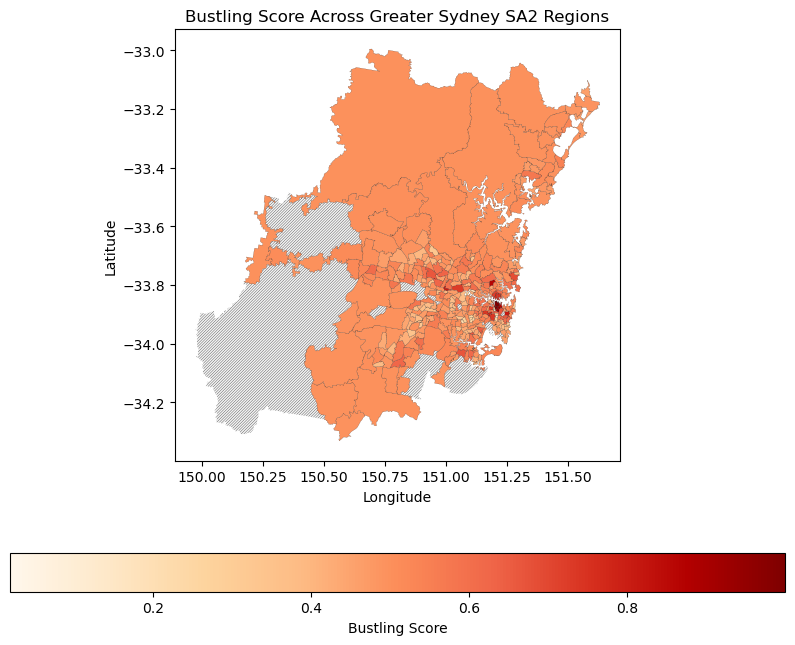

In [191]:
GreaterSydneyRegions = gpd.read_postgis("""
    SELECT S.sa2_name, geom, score
    FROM sa2 S LEFT OUTER JOIN sigmoid_score USING (sa2_code)
""", conn, crs = 4326)

NoDataRegions = GreaterSydneyRegions[GreaterSydneyRegions["score"].isnull()]

fig, ax = plt.subplots(figsize = (10,8))

GreaterSydneyRegions.plot(
    column = "score", 
    ax = ax,
    cmap = "OrRd", 
    linewidth = 0.1, 
    edgecolor = "black", 
    legend = True,
    legend_kwds = {"label" : "Bustling Score", "orientation" : "horizontal"},
)

NoDataRegions.plot(
    ax = ax,
    color = 'gray',
    hatch = '////////////',
    linewidth = 0.1,
    alpha = 0.1,
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Bustling Score Across Greater Sydney SA2 Regions")

plt.show()

#### 3.2.2 Correlations with Income

We can find correlation with the CORR function in SQL which outputs the correlation between income and bustling score over all SA2 Regions.

In [119]:
sql = """
SELECT CORR(score, median_income) AS correlation
FROM sigmoid_score S LEFT OUTER JOIN income I USING (sa2_code)
"""

query(conn,sql)

,correlation
0,0.295309
